In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gudhi as gd
import json

from glob import glob
import os
import tifffile as tf

from scipy import ndimage
from sklearn import manifold, cluster, decomposition, preprocessing

In [2]:
def pers2numpy(pers):
    bd = np.zeros((len(pers), 3), dtype=float)
    for i in range(len(bd)):
        bd[i, 0] = pers[i][0]
        bd[i, 1:] = pers[i][1]
    return bd

def get_diagrams(jsonfiles, ndims):
    # diag[j-th cell][k-th dimension]
    
    diags = [ [np.empty((0,2)) for k in range(ndims)] for j in range(len(jsonfiles))]

    for j in range(len(jsonfiles)):
        
        if jsonfiles[j] is not None:
            with open(jsonfiles[j]) as f:
                diag = [tuple(x) for x in json.load(f)]
            diag = pers2numpy(diag)
        
            for k in range(ndims):
                diags[j][k] = diag[diag[:,0] == k, 1:]

    return diags

def bottleneck_matrix(diagh0, diagh1, dfunction=gd.bottleneck_distance, **kwargs):
    bottleneck_h0 = np.zeros( (len(diagh0), len(diagh0)) )
    bottleneck_h1 = np.zeros( (len(diagh0), len(diagh0)) )
    
    for i in range(len(bottleneck_h0) - 1):
        for j in range(i+1, len(bottleneck_h0)):
    
            ## H0 ##
            d = dfunction(diagh0[i], diagh0[j], **kwargs)
            bottleneck_h0[i,j] = d
            bottleneck_h0[j,i] = d
    
            ## H1 ##
            d = dfunction(diagh1[i], diagh1[j], **kwargs)
            bottleneck_h1[i,j] = d
            bottleneck_h1[j,i] = d

    return bottleneck_h0, bottleneck_h1

def save_dmatrix(mtrx, filename):
    N = len(mtrx)
    dflat = mtrx[np.triu_indices(N, k=1)]
    pd.Series(dflat).to_csv(filename, index=False, header=None)
    print(filename)

    return dflat

In [3]:
stepsize, PP, bw = 3,6,10
ndims = 3
wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
gsrc = '../sublevel/'
ksrc = '../kde/'
sample = 'D2'

ksrc += sample + os.sep
gsrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

transcriptomes = list(metatrans['gene'])
translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)

TT = ['GLYMA_05G092200','GLYMA_17G195900']
tidxs = np.array([np.argwhere(np.asarray(transcriptomes) == TT[i])[0][0] for i in range(len(TT))])
tidxs

array([26, 85])

In [4]:
wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))

wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%50, axis=0)]

maxkde = np.zeros((len(metacell), len(metatrans))) - 1
for i in range(len(maxkde)):
    filename = '{}maxkde_p{}_s{}_bw{}_c{:06d}.csv'.format(ksrc, PP, stepsize, bw, i)
    if os.path.isfile(filename):
        maxkde[i] = np.loadtxt(filename, delimiter=',')

In [5]:
focus = pd.read_csv('../data/D2_data/scattersutton.csv')
focus = focus[focus['Bact'] == 'Infected']
print(focus.shape)

metafocus = np.zeros( (len(focus),1+metacell.shape[1]) )
for i in range(len(metafocus)):
    foo = metacell[metacell['orig_cellID'] == focus.iloc[i,0]].iloc[0,:]
    metafocus[i,0] = foo.name
    metafocus[i,1:] = foo.values
focus

(968, 5)


,Cell.ID..,05G203100 Cytoplasm transcript density,17G195900 Cytoplasm Transcript Density,Cytoplasm Trans Density,Bact
0,743,0.000000,0.006808,0.032141,Infected
1,843,0.000000,0.011731,0.031750,Infected
2,2053,0.000010,0.009777,0.031371,Infected
3,1146,0.000024,0.006606,0.031145,Infected
4,896,0.000000,0.009233,0.031066,Infected
...,...,...,...,...,...
963,1455,0.000000,0.004588,0.008490,Infected
964,2431,0.000000,0.005729,0.008411,Infected
965,1144,0.000106,0.004397,0.008317,Infected
966,753,0.000000,0.004255,0.008198,Infected


In [6]:
transfocus = transcell.loc[tidxs, metacell.loc[metafocus[:,0].astype(int), 'ndimage_cellID'].values.astype(str)]
ratios = (transfocus/np.sum(transfocus.values)).values
print('Max ratio:\t', 100*np.max(ratios), '%')
transfocus

Max ratio:	 0.24671835679793241 %


,742,842,2052,1145,896,2152,558,751,746,236,...,303,1782,1724,1571,1583,1454,2430,1143,752,513
26,249,317,581,307,195,1026,529,686,340,694,...,438,406,187,183,271,241,62,152,396,806
85,363,1239,1022,572,933,1182,531,1808,975,1305,...,228,156,48,62,107,131,49,86,138,371


In [7]:
print(np.sum(ratios > 0, axis=1))
jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]

for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_sublevel_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(metafocus)):
        filename = foo.format(gsrc, transcriptomes[tidxs[i]],transcriptomes[tidxs[i]],PP,stepsize,bw,int(metafocus[j,0]))
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

[968 968]


In [66]:
diags = [None for i in range(len(jsonfiles))]

for i in range(len(diags)):
    diags[i] = get_diagrams(jsonfiles[i], ndims)

for i in range(len(diags)):
    print(len(diags), len(diags[i]), len(diags[i][0]), sep='\t')

numpairs = 0
for i in range(len(diags)):
    for j in range(len(diags[i])):
        for k in range(len(diags[i][j])):
            diags[i][j][k] *= ratios[i][j]
            numpairs += len(diags[i][j][k])

print('Initial number of life-birth pairs\t:', numpairs)
maxx = 0
for i in range(len(diags)):
    for j in range(len(diags[i])):
        if maxx < np.max(diags[i][j][-1]):
            maxx = np.max(diags[i][j][-1])
print('Max value after scaling', maxx)

rescale = 256/maxx
numpairs = 0
minlife = 1

for i in range(len(diags)):
    for j in range(len(diags[i])):
        for k in range(len(diags[i][j])):
            diags[i][j][k] *= rescale
            diags[i][j][k]  = np.atleast_2d(diags[i][j][k][np.diff(diags[i][j][k]).squeeze() > minlife, :].squeeze())
            numpairs += len(diags[i][j][k])

maxx = 0
for i in range(len(diags)):
    for j in range(len(diags[i])):
        if maxx < np.max(diags[i][j][-1]):
            maxx = np.max(diags[i][j][-1])
print('Max value after rescaling', maxx)
print('Final number of life-birth pairs\t:', numpairs)

2	968	3
2	968	3
Initial number of life-birth pairs	: 323058
Max value after scaling 5.735956040648034e-09
Max value after rescaling 256.0
Final number of life-birth pairs	: 110275


In [67]:
diagh = [ [ None for k in range(ndims) ] for i in range(np.sum(ratios > 0)) ]
counter = 0
for i in range(len(diags)):
    for j in np.nonzero(ratios[i] > 0)[0]:
        for k in range(len(diags[i][j])):
            diagh[counter][k] = diags[i][j][k]
        counter += 1

In [69]:
bottleneck = np.zeros((len(diagh),len(diagh)))

for i in range(bottleneck.shape[0] - 1):
    for j in range(i+1, bottleneck.shape[1]):
        dk = np.zeros(ndims)
        for k in range(len(dk)):
            dk[k] = gd.bottleneck_distance(diagh[i][k], diagh[j][k])
        bottleneck[i,j] = np.max(dk)
        bottleneck[j,i] = np.max(dk)
    if i%100 == 0:
        print(i)

0


KeyboardInterrupt: 

In [ ]:
def save_dmatrix(mtrx, filename):
    N = len(mtrx)
    dflat = mtrx[np.triu_indices(N, k=1)]
    pd.Series(dflat).to_csv(filename, index=False, header=None)
    print(filename)

    return dflat

In [19]:
# Bottleneck

h0, h1 = bottleneck_matrix(diag0, diag1, gd.bottleneck_distance)
dmatrix = np.maximum(h0, h1)
filename = tsrc + transcriptomes[tidx] + '_-_' + level + 'level_bottleneck.csv'
dflat = save_dmatrix(dmatrix, filename)

../gd_trans/D2/GLYMA_06G090100_-_superlevel_bottleneck.csv


In [13]:
N = len(jsonfiles)
A = np.zeros((N,N))
A[np.triu_indices(N,k=1)] = dflat
A += A.T
A.shape

(135, 135)

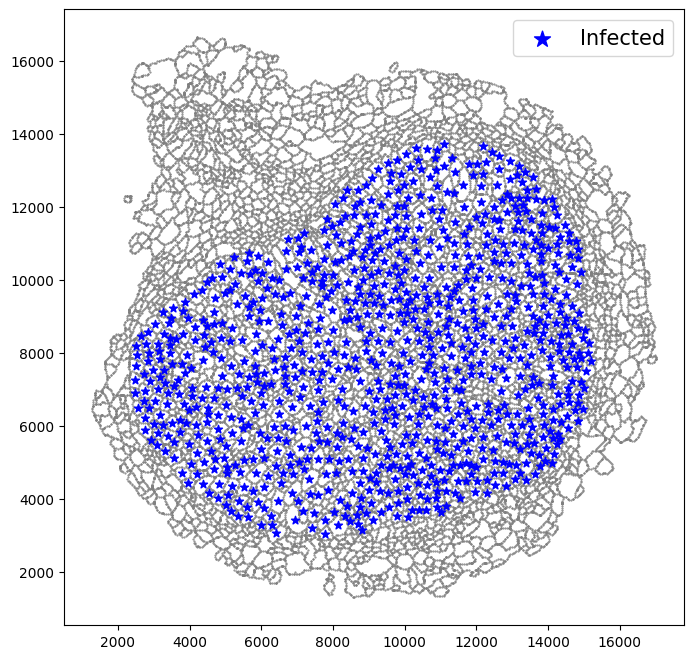

In [86]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = np.atleast_1d(ax).ravel();

ax[0].scatter(wc[1], wc[0], c='gray', marker='.', s=1)
ax[0].scatter(metafocus[:,13], metafocus[:,14], c='blue', marker='*', label='Infected')
ax[0].legend(fontsize=15, markerscale=2);

In [47]:
bdh0, bdh1 = bottleneck_matrix(diag0, diag1, gd.bottleneck_distance)
bd_mtrx = np.maximum(bdh0, bdh1)
dflat = bd_mtrx[np.triu_indices(len(jsonfiles), k=1)]
filename = tsrc + transcriptomes[tidx] + '_-_' + level + 'level_bottleneck.csv'
pd.Series(dflat).to_csv(filename, index=False, header=None)

array([28.5, 30. , 14. , 32. , 34.5, 28.5, 32. , 21. , 34.5, 32. ])

In [8]:
pd.read_csv(filename, header=None)

,0
0,15.0
1,26.0
2,55.0
3,25.0
4,29.0
...,...
9040,56.0
9041,21.0
9042,23.5
9043,30.0
